## Grouping students based on marksheets using K Means Clustering

In [630]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42)

In [631]:
# obtain the raw csv 
data = "../assets/data/student_marksheet.csv"
marksheet_df = pd.read_csv(data)

In [632]:
print(marksheet_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       250 non-null    int64 
 1   Name     250 non-null    object
 2   Gender   250 non-null    object
 3   Age      250 non-null    int64 
 4   Section  250 non-null    object
 5   Science  250 non-null    int64 
 6   English  250 non-null    int64 
 7   History  250 non-null    int64 
 8   Maths    250 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 17.7+ KB
None


In [633]:
print(marksheet_df.head())
marksheet_df_copy = marksheet_df.copy()

   id     Name  Gender  Age Section  Science  English  History  Maths
0   1  Bronnie  Female   13       C       21       81       62     49
1   2   Lemmie    Male   15       B       29       41       17     40
2   3    Danya  Female   14       C       12       87       16     96
3   4    Denna  Female   14       B       15       53       82     33
4   5  Jocelin    Male   14       A       43        6        3     21


In [634]:
# Identifying categorical features
print(marksheet_df["Gender"].unique())
print(marksheet_df["Section"].unique())
print(marksheet_df["Age"].unique())

['Female' 'Male']
['C' 'B' 'A']
[13 15 14]


In [635]:
# Converting categorical data to numeric data
marksheet_df["Gender"].replace({"Female": 0, "Male": 1}, inplace=True)
marksheet_df["Section"].replace({"A": 0, "B": 1, "C": 2}, inplace=True)
marksheet_df["Age"].replace({13: 0, 14: 0.5, 15: 1}, inplace=True)

In [636]:
# Dropping name and id column because it will not be used for clustering
marksheet_df.drop(["Name"], axis=1, inplace=True)
marksheet_df.drop(["id"], axis=1, inplace=True)

In [637]:
print(marksheet_df.shape)
print(marksheet_df.head())

(250, 7)
   Gender  Age  Section  Science  English  History  Maths
0       0  0.0        2       21       81       62     49
1       1  1.0        1       29       41       17     40
2       0  0.5        2       12       87       16     96
3       0  0.5        1       15       53       82     33
4       1  0.5        0       43        6        3     21


In [638]:
X_mean = marksheet_df.mean(axis=0, numeric_only=True)
X_std = marksheet_df.std(axis=0, numeric_only=True)

# Normalizing the data
marksheet_df = (marksheet_df - X_mean) / X_std

print(marksheet_df.head())

     Gender       Age   Section   Science   English   History     Maths
0 -1.055542 -1.238469  1.146226 -1.038394  1.102541  0.362059 -0.146642
1  0.943591  1.189901 -0.062873 -0.765492 -0.233063 -1.312763 -0.475272
2 -1.055542 -0.024284  1.146226 -1.345409  1.302881 -1.349981  1.569537
3 -1.055542 -0.024284 -0.062873 -1.243071  0.167618  1.106425 -0.730873
4  0.943591 -0.024284 -1.271972 -0.287912 -1.401716 -1.833819 -1.169047


In [639]:
def get_distance(x, y):
    dist = 0
    dist += 0.5*(np.abs(x[0] - y[0]))
    if (x[1] != y[1]):
        dist += 0.5
    dist += 10*np.abs(x[2] - y[2])
    dist += 10*np.abs(x[3] - y[3])
    dist += 10*np.abs(x[4] - y[4])
    dist += 10*np.abs(x[5] - y[5])

    return dist

In [640]:
# Initialize the centroids randomly
def init_centroids(K, marksheet_df):
    centroids = set()

    while(len(centroids) != K):
        random_index = random.randint(0, len(marksheet_df)-1)
        z = tuple(marksheet_df.iloc[random_index, -7:])
        centroids.add(z)

    # Convert the set to a list
    centroids = list(centroids)

    return centroids

In [641]:
# Clusters are assigned with the prior knowledge of centroids
def assign_clusters(K, centroids, marksheet_df):
    clusters = [[] for _ in range(K)]
    
    # Assign each data point to its closest centroid
    for i in range(len(marksheet_df)):
        min_dist = float("inf")
        idx = 0
        
        for j in range(len(centroids)):
            dist = get_distance(centroids[j], marksheet_df.loc[i])
            if dist < min_dist:
                min_dist = dist
                idx = j

        clusters[idx].append(i)  # Append index of data point
    
    return clusters

In [642]:
# Centroids of each cluster are updated with the prior knowledge of clusters
def update_centroids(K, clusters):
    centroids = []
    for i in range(K):
        sum = 0
        for j in range(len(clusters[i])):
            sum += np.array(marksheet_df.iloc[clusters[i][j]])
        sum /= len(clusters[i])
        centroids.append(sum)
    
    return centroids

In [643]:
def get_dissimilarity(clusters, centroids, marksheet_df):
    dissimilarity = 0
    for i in range(len(clusters)):
        cluster_variance = 0
        for j in range(len(clusters[i])):
            cluster_variance += get_distance(marksheet_df.loc[clusters[i][j]], centroids[i])

        dissimilarity += cluster_variance

    return dissimilarity


In [644]:
def fit(K, marksheet_df, num_iterations=100):
    # Initialize the centroids
    centroids = init_centroids(K, marksheet_df)
    total_dissimilarity = []
    clusters = [[] for _ in range(K)]
    prev_clusters = [[] for _ in range(K)]

    for m in range(num_iterations):
        # Clusters are assigned with the prior knowledge of centroids
        clusters = assign_clusters(K, centroids, marksheet_df)

        # Centroids of each cluster are updated with the prior knowledge of clusters
        centroids = update_centroids(K, clusters)

        # Get dissimilarity score
        dissimilarity_score = get_dissimilarity(clusters, centroids, marksheet_df)
        total_dissimilarity.append(dissimilarity_score)

        if (m % 10 == 0):
            print(f'Completed iteration: {m} with dissimilarity score: {dissimilarity_score}')
        
        if (prev_clusters == clusters):
            print(f'Algorithm Converged at iteration {m}')
            break

        prev_clusters = clusters

    return clusters, centroids, total_dissimilarity

In [645]:
K = 75
clusters, centroids, total_dissimilarity = fit(K, marksheet_df)

Completed iteration: 0 with dissimilarity score: 1983.9642682828432
Algorithm Converged at iteration 7


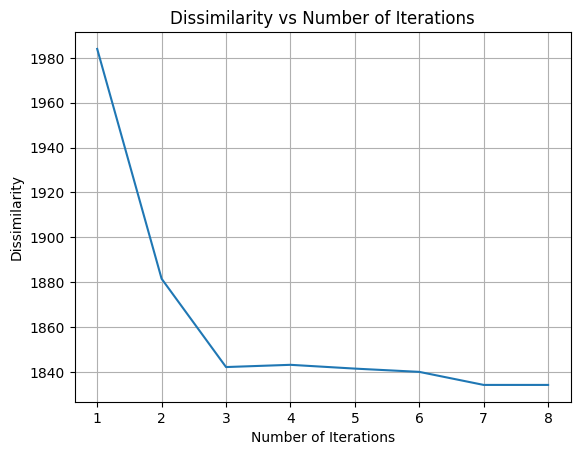

In [646]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(total_dissimilarity) + 1), total_dissimilarity)
plt.xlabel('Number of Iterations')
plt.ylabel('Dissimilarity')
plt.title('Dissimilarity vs Number of Iterations')
plt.grid(True)
plt.show()

In [648]:
# Print all groups
# for i in range(len(clusters)):
#     print(f'Group {i}: ')
#     for j in range(len(clusters[i])):
#         print(np.array(marksheet_df_copy.loc[clusters[i][j]]))
#     print(f'Centroid: {np.array(centroids[i] * X_std + X_mean).round(1)}')
#     print("")

# Print specific groups
groups = [0, 9, 27]

for i in groups:
    print(f'Group {i}: ')
    for j in range(len(clusters[i])):
        print(np.array(marksheet_df_copy.loc[clusters[i][j]]))
    print(f'Centroid: {np.array(centroids[i] * X_std + X_mean).round(1)}')
    print("")

Group 0: 
[16 'Gilberta' 'Male' 15 'A' 53 30 90 64]
[28 'Hanan' 'Male' 14 'A' 60 36 86 87]
[96 'Georgia' 'Female' 15 'A' 58 10 99 44]
Centroid: [ 0.7  0.8  0.  57.  25.3 91.7 65. ]

Group 9: 
[11 'Dunn' 'Male' 15 'C' 100 93 87 81]
[179 'Val' 'Male' 13 'B' 95 73 91 61]
Centroid: [ 1.   0.5  1.5 97.5 83.  89.  71. ]

Group 27: 
[24 'Valma' 'Female' 14 'C' 48 83 79 95]
[79 'Rosalynd' 'Male' 13 'C' 27 96 89 49]
[147 'Jaquenette' 'Male' 15 'C' 33 75 98 84]
[209 'Zenia' 'Female' 14 'C' 59 94 94 47]
Centroid: [ 0.5  0.5  2.  41.8 87.  90.  68.8]

